# Text classification

<a id='imp'></a>
## Importing packages and loading data

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [2]:
# loading data
df = pd.read_csv('complaints.csv')
df.shape

(4051252, 18)

<a id='eda'></a>
## Exploratory Data Analysis (EDA) and Feature Engineering

In [3]:
df.head(2).T # Columns are shown in rows for easy reading

,0,1
Date received,2023-08-25,2023-08-25
Product,Credit reporting or other personal consumer re...,Credit reporting or other personal consumer re...
Sub-product,Credit reporting,Credit reporting
Issue,Incorrect information on your report,Improper use of your report
Sub-issue,Information belongs to someone else,Credit inquiries on your report that you don't...
Consumer complaint narrative,NaN,NaN
Company public response,NaN,NaN
Company,"EQUIFAX, INC.","EQUIFAX, INC."
State,FL,MI
ZIP code,33009,48234


The dataset contains features that are not necessary to solve our multi-classification problem. For this text classification problem, we are going to build another dataframe that contains ‘Product’ and ‘Consumer complaint narrative’ (renamed as 'Consumer_complaint').

In [4]:
# Create a new dataframe with two columns
df1 = df[['Product', 'Consumer complaint narrative']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

# Renaming second column for a simpler name
df1.columns = ['Product', 'Consumer_complaint'] 

df1.shape

(1466306, 2)

In [5]:
# Percentage of complaints with text
total = df1['Consumer_complaint'].notnull().sum()
round((total/len(df)*100),1)

36.2

From more than 1 million complaints, there are about 380,000 cases with text (~ 30% of the original dataset is not null). This is still a good number to work with. Now let's have a look at the categories we want to classify each complaint.

In [6]:
pd.DataFrame(df.Product.unique()).values

array([['Credit reporting or other personal consumer reports'],
       ['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Debt collection'],
       ['Mortgage'],
       ['Checking or savings account'],
       ['Credit card or prepaid card'],
       ['Payday loan, title loan, or personal loan'],
       ['Student loan'],
       ['Vehicle loan or lease'],
       ['Credit card'],
       ['Money transfer, virtual currency, or money service'],
       ['Debt or credit management'],
       ['Bank account or service'],
       ['Payday loan, title loan, personal loan, or advance loan'],
       ['Credit reporting'],
       ['Payday loan'],
       ['Prepaid card'],
       ['Consumer Loan'],
       ['Money transfers'],
       ['Other financial service'],
       ['Virtual currency']], dtype=object)

There are 18 different classes or categories (target). However; it is observed that some classes are contained in others. For instance, ‘Credit card’ and ‘Prepaid card’ are contained in ‘Credit card or prepaid card’ category. Now, imagine there is a new complaint about Credit card and we want to classify it. The algorithm can either classify this complaint as 'Credit card' or 'Credit card or prepaid' and it would be correct. Nevertheless, this would affect model performance. In order to avoid this problem, the names of some categories were renamed.

In [7]:
# Because the computation is time consuming (in terms of CPU), the data was sampled
df2 = df1.sample(10000, random_state=1).copy()

In [8]:
# Renaming categories
df2.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other', 
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)

In [9]:
pd.DataFrame(df2.Product.unique())

,0
0,Debt collection
1,"Credit reporting, repair, or other"
2,Student loan
3,Checking or savings account
4,Bank account or service
5,Credit card or prepaid card
6,"Money transfer, virtual currency, or money ser..."
7,Vehicle loan or lease
8,Mortgage
9,Consumer Loan


The number of classes were reduced from 18 to 13. <br><br>Now we need to represent each class as a number, so as our predictive model can better understand the different categories.

In [10]:
# Create a new column 'category_id' with encoded categories 
df2['category_id'] = df2['Product'].factorize()[0]
category_id_df = df2[['Product', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

# New dataframe
df2.head()

,Product,Consumer_complaint,category_id
640592,Debt collection,On XXXX I received a collection attempt from P...,0
3748140,"Credit reporting, repair, or other",The financial institutions listed below contin...,1
1081027,"Credit reporting, repair, or other","As starters, the U.S. Bankruptcy Court provide...",1
352179,"Credit reporting, repair, or other",This is an unfair system to be ignored and tak...,1
810165,Debt collection,on or around XX/XX/2017 I started receiving no...,0


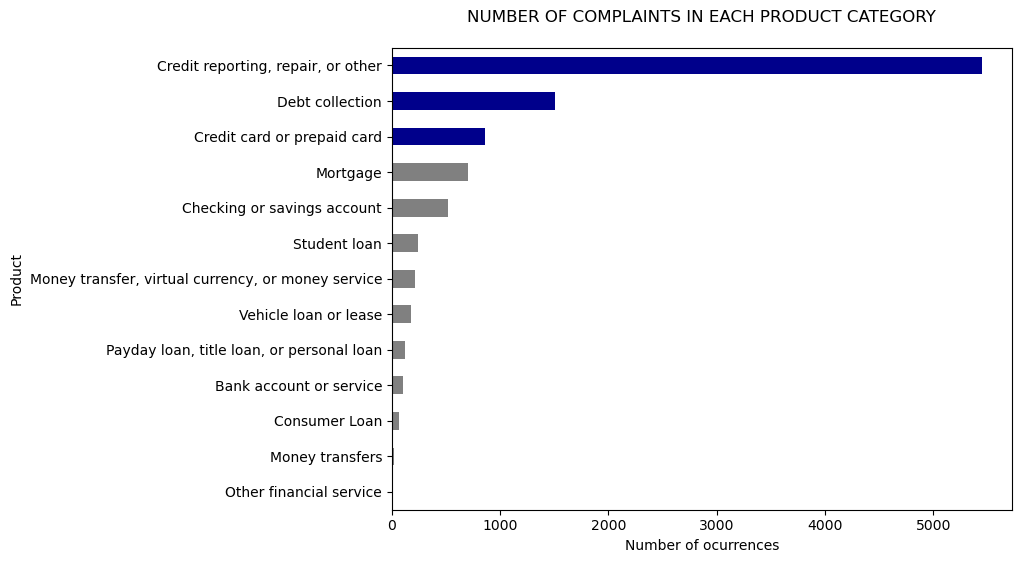

In [11]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df2.groupby('Product').Consumer_complaint.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [12]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df2.Consumer_complaint).toarray()

labels = df2.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 10000 complaints is represented by 26186 features (TF-IDF score of unigrams and bigrams)


In [13]:
# Finding the three most correlated terms with each of the product categories
N = 3
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("\n==> %s:" % (Product))
    print("  * Most Correlated Unigrams are: %s" % (', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" % (', '.join(bigrams[-N:])))


==> Bank account or service:
  * Most Correlated Unigrams are: overdrawn, overdraft, citigold
  * Most Correlated Bigrams are: overdraft fees, xxxx overdraft, citigold checking

==> Checking or savings account:
  * Most Correlated Unigrams are: deposit, chime, bank
  * Most Correlated Bigrams are: debit card, direct deposit, checking account

==> Consumer Loan:
  * Most Correlated Unigrams are: ally, repo, vehicle
  * Most Correlated Bigrams are: big picture, picture loans, got car

==> Credit card or prepaid card:
  * Most Correlated Unigrams are: charges, amex, card
  * Most Correlated Bigrams are: card company, american express, credit card

==> Credit reporting, repair, or other:
  * Most Correlated Unigrams are: 1681, section, reporting
  * Most Correlated Bigrams are: credit report, 15 1681, 1681 section

==> Debt collection:
  * Most Correlated Unigrams are: collect, collection, debt
  * Most Correlated Bigrams are: collection agency, debt collection, collect debt

==> Money tr

<a id='sp'></a>
### Spliting the data into train and test sets
The original data was divided into features (X) and target (y), which were then splitted into train (75%) and test (25%) sets. Thus, the algorithms would be trained on one set of data and tested out on a completely different set of data (not seen before by the algorithm).

In [14]:
X = df2['Consumer_complaint'] # Collection of documents
y = df2['Product'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

<a id='m'></a>
### Models

In [15]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/Users/phanindrasai/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/phanindrasai/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/phanindrasai/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/phanindrasai/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set t

<a id='sum'></a>
## Comparison of model performance

The best mean acuracy was obtained with LinearSVC.

In [20]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.8315,0.004228
LogisticRegression,0.8083,0.003818
MultinomialNB,0.6838,0.004339
RandomForestClassifier,0.5453,0.000274


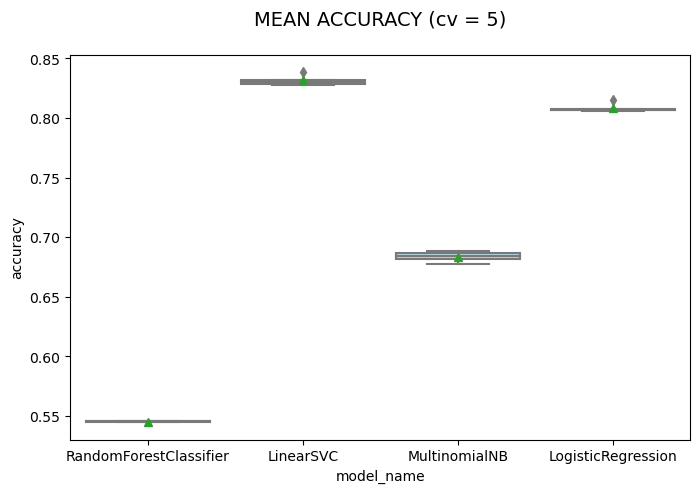

In [21]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

<a id='ev'></a>
## Model Evaluation

In [22]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df2.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/Users/phanindrasai/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


<a id='cm'></a>
### Confusion Matrix

A Confusion Matrix is a table which rows represent the actual class and columns represents the predicted class.<br><br>
If we had a perfect model that always classifies correctly a new complaint, then the confusion matrix would have values in the diagonal only (where predicted label = actual label).

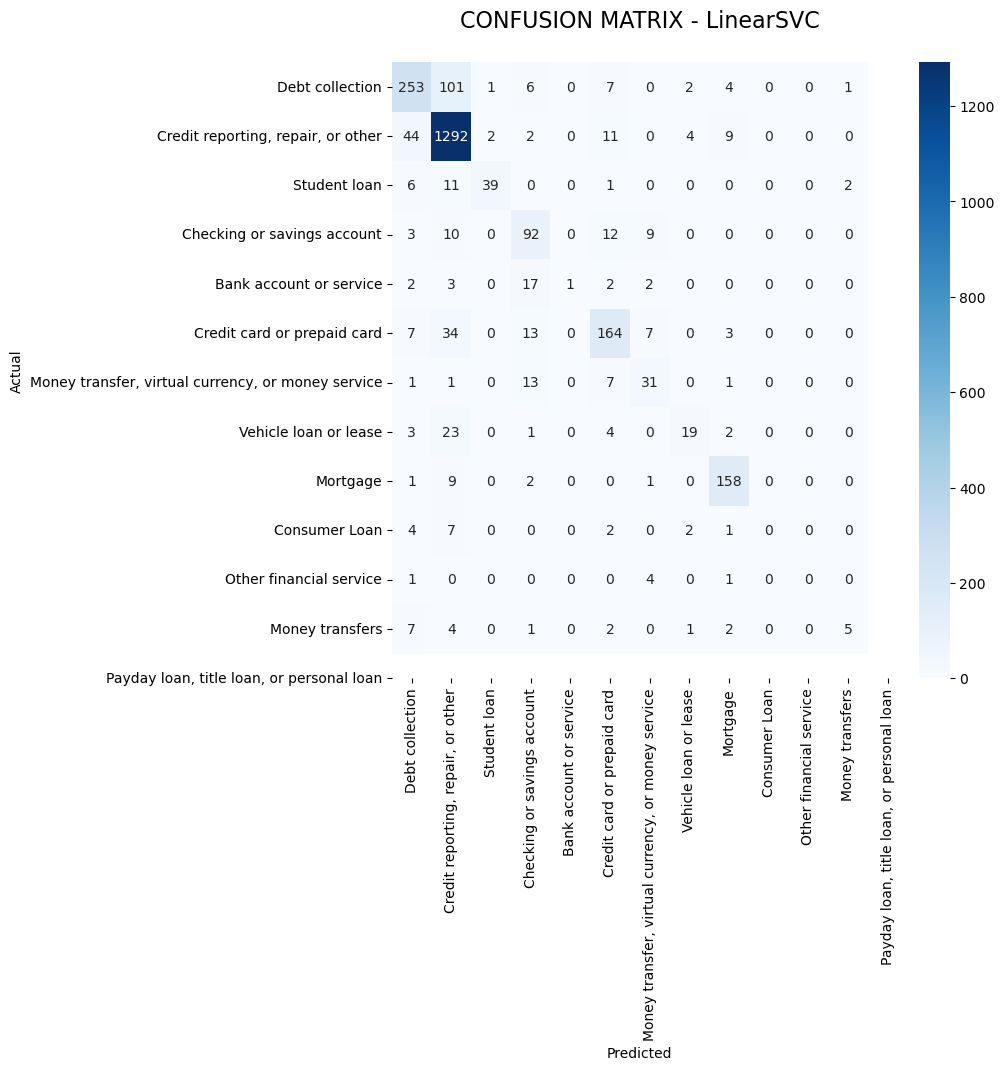

In [29]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values, 
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In general, the confusion matrix looks good (clear diagonal that represents correct classifications). Nevertheless, there are cases were the complaint was classified in a wrong class.

#### Misclassified complaints
Let’s have a look at the cases that were wrongly classified.

In [32]:
unique_categories = df2['Product'].unique()
print(len(unique_categories))
print(unique_categories)

13
['Debt collection' 'Credit reporting, repair, or other' 'Student loan'
 'Checking or savings account' 'Bank account or service'
 'Credit card or prepaid card'
 'Money transfer, virtual currency, or money service'
 'Vehicle loan or lease' 'Mortgage' 'Consumer Loan'
 'Other financial service' 'Money transfers'
 'Payday loan, title loan, or personal loan']


In [ ]:
for predicted in range(len(category_id_df.category_id)):
    for actual in range(len(category_id_df.category_id)):
        if predicted != actual and conf_mat[actual, predicted] >= 20:
            print("'{}' predicted as '{}' : {} examples.".format(
                id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            indices = indices_test[(y_test == actual) & (y_pred == predicted)]
            display(df2.loc[indices][['Product', 'Consumer_complaint']])

#### Most correlated terms with each category

In [33]:
model.fit(features, labels)

N = 4
for Product, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    
    # Check if indices are within bounds
    valid_indices = [idx for idx in indices if idx < features.shape[1]]
    
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    
    print("\n==> '{}':".format(Product))
    print("  * Top unigrams: %s" %(', '.join(unigrams)))
    print("  * Top bigrams: %s" %(', '.join(bigrams)))

/Users/phanindrasai/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



==> 'Bank account or service':
  * Top unigrams: citigold, bank, honor, 2016
  * Top bigrams: xxxx 2016, hold money, xxxx overdraft, overdraft fees

==> 'Checking or savings account':
  * Top unigrams: bank, chime, account, deposit
  * Top bigrams: debit card, charged overdraft, savings account, chase bank

==> 'Consumer Loan':
  * Top unigrams: vehicle, auto, apr, ally
  * Top bigrams: discover credit, got car, big picture, picture loans

==> 'Credit card or prepaid card':
  * Top unigrams: card, amex, capital, citi
  * Top bigrams: balance transfer, care credit, account fraud, money checking

==> 'Credit reporting, repair, or other':
  * Top unigrams: equifax, experian, report, transunion
  * Top bigrams: xxxx xxxx, late payments, score dropped, xxxx reporting

==> 'Debt collection':
  * Top unigrams: debt, collection, collections, recovery
  * Top bigrams: inaccurate accounts, claiming owe, bank account, verification information

==> 'Money transfer, virtual currency, or money serv

<a id='pred'></a>
## Predictions

Now let's make a few predictions on unseen data.<br>

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

/Users/phanindrasai/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Let's see what is the classification that our model gives to this new complaint.

In [35]:
new_complaint = """I have been enrolled back at XXXX XXXX University in the XX/XX/XXXX. Recently, i have been harassed by \
Navient for the last month. I have faxed in paperwork providing them with everything they needed. And yet I am still getting \
phone calls for payments. Furthermore, Navient is now reporting to the credit bureaus that I am late. At this point, \
Navient needs to get their act together to avoid me taking further action. I have been enrolled the entire time and my \
deferment should be valid with my planned graduation date being the XX/XX/XXXX."""
print(model.predict(fitted_vectorizer.transform([new_complaint])))

['Student loan']


The algorithm has classified this text as a "Student loan" complaint. Now let's look at the real label of this complaint.

Our model was correct, the complaint was about **Student Loan**. Note that this customer has used terms with high TFIDF score, such us **Navient[](http://)**.<br><br>
Let's check another example.

In [37]:
new_complaint_2 = """Equifax exposed my personal information without my consent, as part of their recent data breach. \
In addition, they dragged their feet in the announcement of the report, and even allowed their upper management to sell \
off stock before the announcement."""
print(model.predict(fitted_vectorizer.transform([new_complaint_2])))

['Credit reporting, repair, or other']
